The objective of this project is determining which employees will leave the company based on the following factor:
- Satisfaction Level
- How their perfomance was last evaluated
- Number of Projects Done
- Time spent at the company (years)
- If there was a work accident
- If they were promoted in the last 5 years
- Department
- Salary

In [1]:
#Importing necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

Next we are going to read the data to see if there is missing data, what type of data there is and how many entries we have.

In [2]:
#Reading data
df = pd.read_csv("data/HR_capstone_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


There are no null values so we won't need to come up with strategies to deal with missing values
We have 2 float columns, 6 int columns and 2 object columns

Now, we will check the first 5 entries of our data

In [3]:
#Example of first five entries of data
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


it seems like left, work_accident and promotion_last_5years are binary values.
Let's check their value counts

In [4]:
#Checking balance of target variable
df['left'].value_counts(1)

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

Our dataset is imbalanced, only 23.8% of the employees left the company, we will have to apply a resampling technique later when training machine learning models. 

In [5]:
df['Work_accident'].value_counts(1)

Work_accident
0    0.85539
1    0.14461
Name: proportion, dtype: float64

14.46% of the employees suffered an work accident, it might be useful to predict if a employee will leave. Let's see how many people who suffered an accident left the company

In [6]:
work_acc_df = df.groupby('Work_accident')['left'].agg(['count','sum']).reset_index()
work_acc_df.columns = ['Work_accident','number of employees','number of employees who left']
work_acc_df

,Work_accident,number of employees,number of employees who left
0,0,12830,3402
1,1,2169,169


- Only 169 of 2169 employees (7,7%) who had an accident left
- Of those who have not had an accident, 3402 (26,51%) left

In [7]:
df['promotion_last_5years'].value_counts(1)

promotion_last_5years
0    0.978732
1    0.021268
Name: proportion, dtype: float64

- Only 2.1% of employees were promoted in the last five years. Let's see if they stayed there.
- Promotion info might be too imbalanced to make a prediction with

In [8]:
promo_df = df.groupby('promotion_last_5years')['left'].agg(['count','sum']).reset_index()
promo_df.columns = ['promotion_last_5years','number of employees','number of employees who left']
promo_df

,promotion_last_5years,number of employees,number of employees who left
0,0,14680,3552
1,1,319,19


- 6% of employees who were promoted left vs 24% who weren't promoted left

Now we will check how our data looks like

We will split our columns based of their data type to make plotting easier

In [9]:
cat_columns = [ 'Department', 'salary']
binary_columns = ['Work_accident', 'left','promotion_last_5years']
small_range_columns = ['number_project','time_spend_company']
large_range_columns = ['satisfaction_level', 'last_evaluation','average_montly_hours']
target_columns = ['left']

We've grouped the columns based on their range of values and their data type 

Now we will make plotting functions to make plotting easier and more reproducible

The function below makes bar charts to compare values of specific group

In [10]:
def bar_plotter(df, column_name, target_column):
    value_counts = df.groupby(column_name)[target_column].agg(['count','sum']).reset_index()
    value_counts.columns = [column_name,'Total',target_column]
    negative_column = "No " + target_column 
    value_counts[negative_column] = value_counts['Total'] - value_counts[target_column]

    # Melt the DataFrame to have both target_column and negative_column in the same column
    melted_df = pd.melt(value_counts, id_vars=[column_name], value_vars=[target_column, negative_column],
                        var_name='Type', value_name='Count')

    # Plot bar chart for each categorical value using Seaborn
    plt.figure(figsize=(10, 9))  
    ax = sns.barplot(data=melted_df, x=column_name, y='Count', hue='Type')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Count')
    plt.legend(title=None)

    # Add text labels to the bars
    for p in ax.patches:
        if p.get_height() != 0:  # Skip annotating when count is zero
            ax.annotate(format(p.get_height(), '.0f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 9), 
                        textcoords='offset points')

    plt.show()



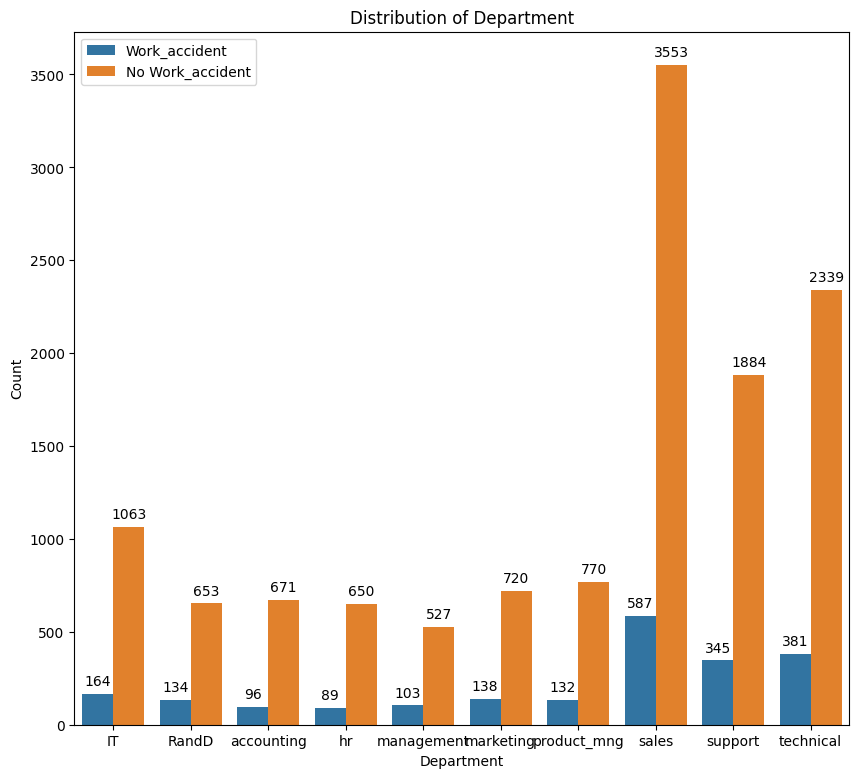

In [11]:
bar_plotter(df,cat_columns[0],binary_columns[0])

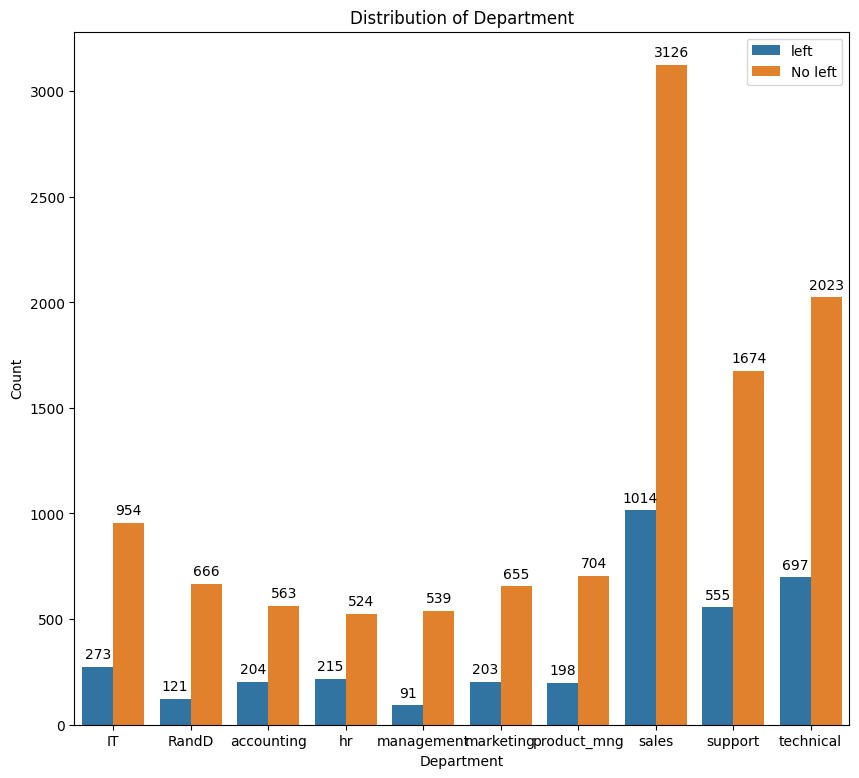

In [12]:
bar_plotter(df,cat_columns[0],binary_columns[1])

- Most people who left were from sales followed by technical and support
- These were also the departments with most people, we will explore later if department is significant enough to affect it

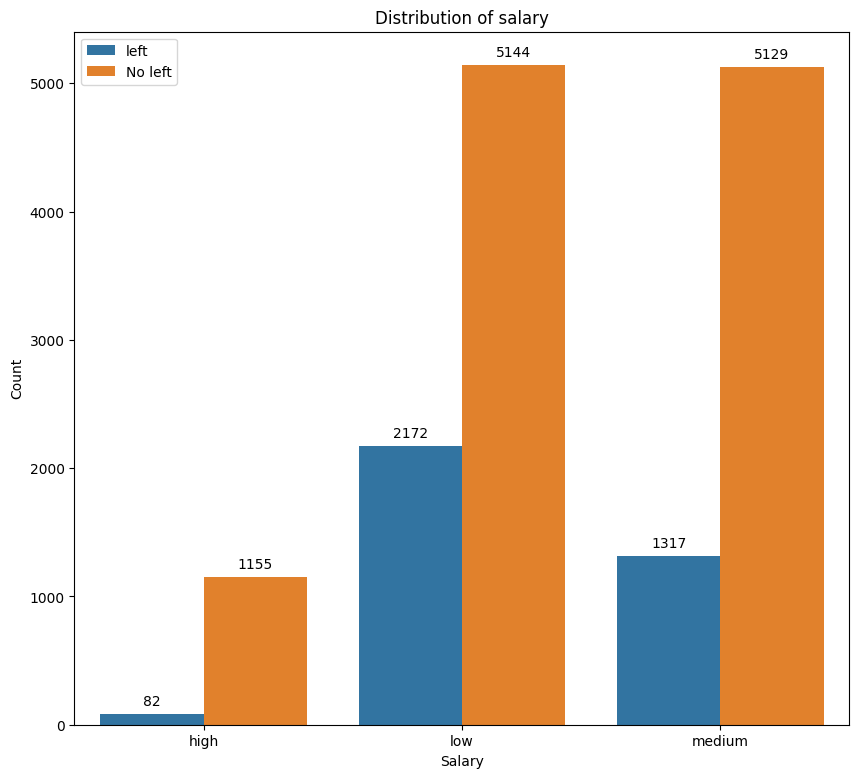

In [13]:
bar_plotter(df,cat_columns[1],'left')

- Only 1237 (8.34%) employees consider their salary high.
- A higher proportion of people with low salary left

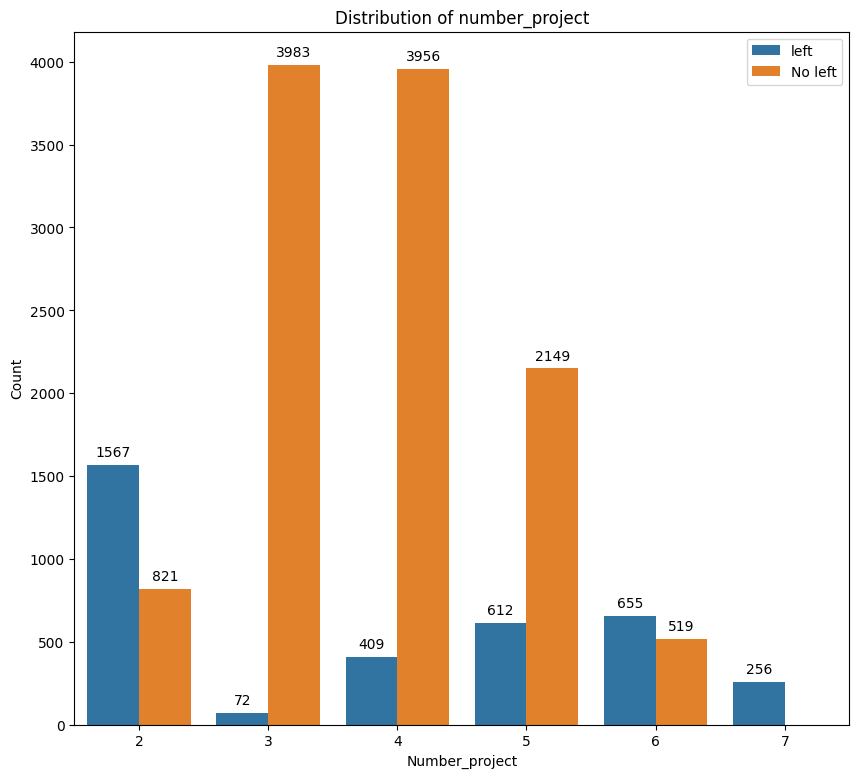

In [14]:
bar_plotter(df,small_range_columns[0],'left')

- Everyone who made 7 projects on the company left, that info really stands out. We will plot a scatter plot later to compare it with years spent at the company and from which department they were
- Most people who made between 3 and 5 projects stayed


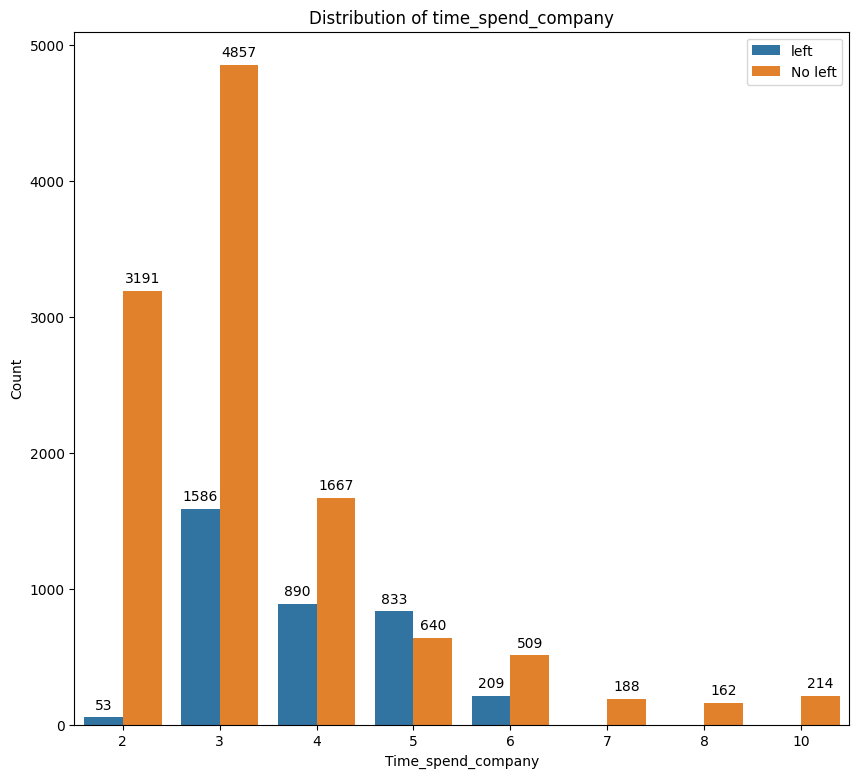

In [15]:
bar_plotter(df,small_range_columns[1],'left')

- Most people who quit were on their third year at the company followed by fourth and fifth
- No one quit after seventh year and almost none quite in their second year
- This might be a very useful data


Next we will create another function to make plotting easier for large range values

In [17]:
def hist_plotter(df, column_name, target_column):
    # Retrieve the specified columns from the DataFrame
    result = df[[column_name, target_column]]
    
    # Create the label column based on the values in the target_column
    result.loc[:,target_column] = result[target_column].astype('category').map({1: 'Yes', 0: 'No'})

    
    # Define custom color palette for labels
    palette = {'Yes': 'red', 'No': 'blue'}
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=result, x=column_name, hue=target_column, palette=palette, multiple='stack', bins=10)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    
    # Create custom legend
    legend_labels = [plt.Rectangle((0,0),1,1, color=palette[label]) for label in palette.keys()]
    plt.legend(legend_labels, palette.keys(), title=target_column)
    
    plt.show()

C:\Users\danie\AppData\Local\Temp\ipykernel_16664\2666286562.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Yes', 'Yes', 'Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
Length: 14999
Categories (2, object): ['No', 'Yes']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:,target_column] = result[target_column].astype('category').map({1: 'Yes', 0: 'No'})


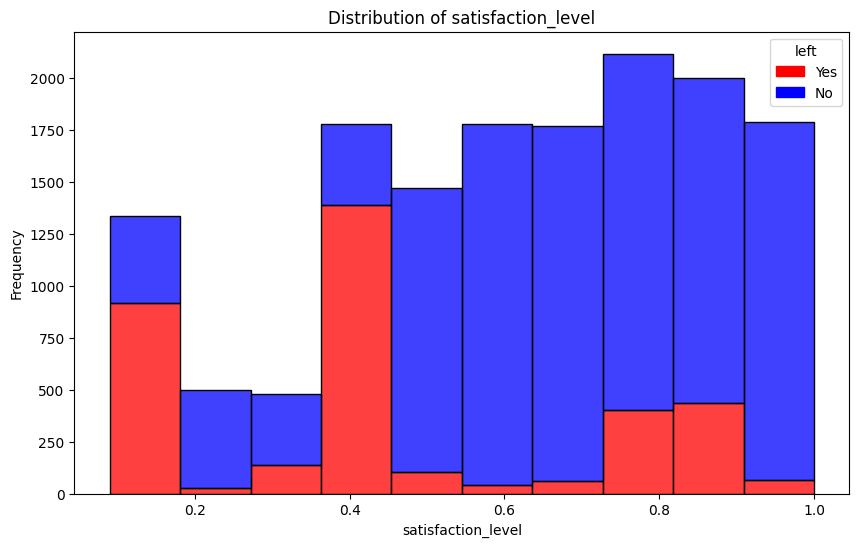

In [19]:
hist_plotter(df,large_range_columns[0],'left')

- Most people who quit had a low satisfaction level

C:\Users\danie\AppData\Local\Temp\ipykernel_16664\2666286562.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Yes', 'Yes', 'Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
Length: 14999
Categories (2, object): ['No', 'Yes']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:,target_column] = result[target_column].astype('category').map({1: 'Yes', 0: 'No'})


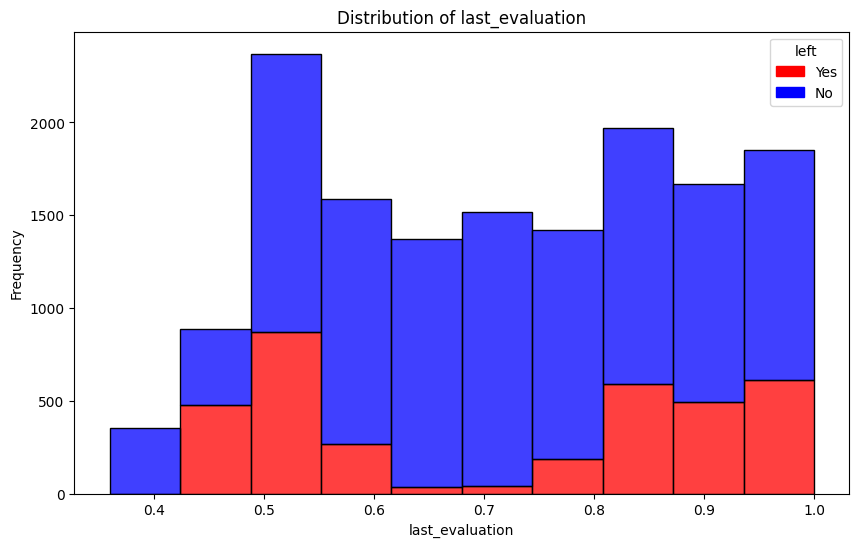

In [20]:
hist_plotter(df,large_range_columns[1],'left')

- Both people who were on lower end and higher end of the evaluation score left. There was less turnover on the middle of evaluation scores

C:\Users\danie\AppData\Local\Temp\ipykernel_16664\2666286562.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Yes', 'Yes', 'Yes', 'Yes', 'Yes', ..., 'Yes', 'Yes', 'Yes', 'Yes', 'Yes']
Length: 14999
Categories (2, object): ['No', 'Yes']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result.loc[:,target_column] = result[target_column].astype('category').map({1: 'Yes', 0: 'No'})


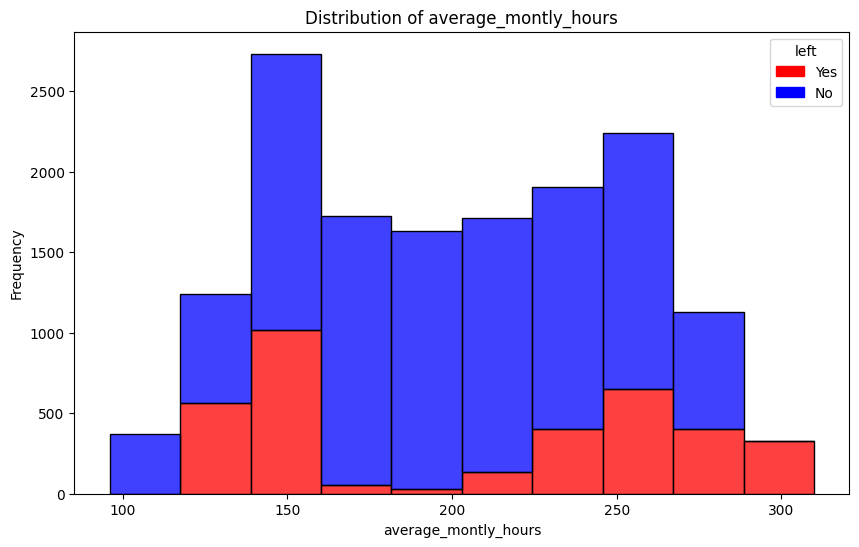

In [23]:
hist_plotter(df,large_range_columns[2],'left')

- There is the same behaviour when plotting average_monthly_hours. Less turnover on middle spectrum of values.